# Use RNN for NLP and test it out with the Kaggle Movie Review Data Set.
#### Data Set: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

In [13]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.preprocessing import sequence

In [14]:
#Preprocess the data.
movie_reviews = pd.read_csv('data/train.tsv', sep='\t')
movie_reviews = movie_reviews[['Phrase', 'Sentiment']]
movie_reviews['Phrase'] = movie_reviews['Phrase'].str.lower()
movie_reviews['Phrase'] = movie_reviews['Phrase'].str.replace(r'[^a-z ]*', '', regex=True)

print("Largest phrase: {}".format(movie_reviews['Phrase'].str.len().max()))
print("\n")
print(movie_reviews[0:10].to_string())

Largest phrase: 265


                                              Phrase  Sentiment
0  a series of escapades demonstrating the adage ...          1
1  a series of escapades demonstrating the adage ...          2
2                                           a series          2
3                                                  a          2
4                                             series          2
5  of escapades demonstrating the adage that what...          2
6                                                 of          2
7  escapades demonstrating the adage that what is...          2
8                                          escapades          2
9  demonstrating the adage that what is good for ...          2


In [15]:
# Create a vocabulary to id mapping.
stop_words = ['the', 'a', 'of', 'and', 'to', 's', 'in', 'is', 'its', 'an', 'be', 'by', 'at', 'rrb', 'lrb', 'i', 
              'you' 'it', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
              'she', "she's", 'her', 'hers', 'herself']

phrases = movie_reviews['Phrase']
review_corpus = ' '.join(phrases.tolist())
tokens = nltk.word_tokenize(review_corpus)
words = [t for t in tokens if t not in stop_words]

int_to_vocab = dict(enumerate(set(words)))
vocab_to_int = dict(zip(int_to_vocab.values(), int_to_vocab.keys()))

def verify_lookups(i2v, v2i):
    for k in i2v:
        v = i2v[k]
        if k != v2i[v]:
            print('not matching, {0}'.format(v))
    print('works')

verify_lookups(int_to_vocab, vocab_to_int)

works


In [16]:
# define lookup functions
def get_vocab_id(word):
    return vocab_to_int.get(word, None)

def get_id_vocab(id):
    return int_to_vocab.get(id, None)

In [17]:
#Divide into train, validate, and validation sets
train, validate =  np.split(movie_reviews.sample(frac=1), [int(.8*len(movie_reviews))])

train_x, train_y = train['Phrase'], train['Sentiment']
validate_x, validate_y = validate['Phrase'], validate['Sentiment']

print("Lenght of training set: {0} \nLength of Validation set: {1}"
      .format(len(train), len(validate)))

Lenght of training set: 124848 
Length of Validation set: 31212


(array([ 1360.,     0.,  5571.,     0.,     0., 15823.,     0.,  6611.,
            0.,  1847.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

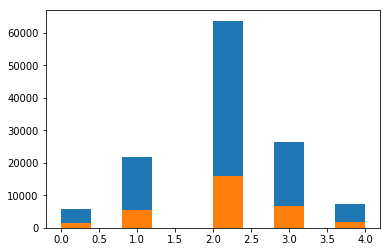

In [18]:
# Just to make sure we didn't mess up the distributions print out the sentiment distributions of the sets.
train_distribution = train.groupby(by='Sentiment').count().reset_index()
validate_distribution = validate.groupby(by='Sentiment').count().reset_index()

plt.hist(train_distribution['Sentiment'], weights=train_distribution['Phrase'])
plt.hist(validate_distribution['Sentiment'], weights=validate_distribution['Phrase'])

In [19]:
# Functions to convert the values to their ids.
def convert_vocab_to_id(phrase):
    phrase_ids = []
    for w in phrase.split(' '):
        id = vocab_to_int.get(w, None)
        if id:
            phrase_ids.append(id)
        else:
            continue
    return phrase_ids

print("PHRASE IN TEXT: {}".format(movie_reviews['Phrase'][0]))
print("CONVERTED PHRASE: {}".format(convert_vocab_to_id(movie_reviews['Phrase'][0])))

train_X = train_x.map(lambda phrase: convert_vocab_to_id(phrase))
validate_X = validate_x.map(lambda phrase: convert_vocab_to_id(phrase))

print("\nBefore")
print(train_x[:2])
print("\nAfter")
print(train_X[:2])

PHRASE IN TEXT: a series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story 
CONVERTED PHRASE: [194, 5398, 15244, 6137, 1472, 7459, 8010, 3766, 8997, 1417, 8010, 3766, 11778, 4102, 13549, 1262, 3777, 4066, 4662, 13549, 7549, 9837, 13458]

Before
60320     to fashion a brazillike  hyperreal satire
112873                 the selfesteem of employment
Name: Phrase, dtype: object

After
60320     [9786, 4237, 3956, 11559]
112873                 [7414, 8675]
Name: Phrase, dtype: object


In [20]:
# One hot code the targets.
hot_encoded_targets = pd.get_dummies(train_y.unique()).to_dict()
targets_mapping = {k:list(v.values()) for k, v in hot_encoded_targets.items()}
print(targets_mapping)

Y_train = train_y.map(lambda target: targets_mapping[target]).tolist()
Y_validate = validate_y.map(lambda target: targets_mapping[target]).tolist()

{0: [0, 0, 0, 1, 0], 1: [0, 0, 1, 0, 0], 2: [1, 0, 0, 0, 0], 3: [0, 1, 0, 0, 0], 4: [0, 0, 0, 0, 1]}


In [21]:
# Hyper parameters
max_phrase_size = movie_reviews['Phrase'].str.len().max()
vocabulary_size = len(int_to_vocab)
embedding_size = 256
batch_size = 256
num_of_epochs = 5

In [22]:
# Build the model

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_phrase_size, name='embedding_layer'))

model.add(LSTM(128,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2,return_sequences=False))

model.add(Dense(5, activation='softmax', name='dense_layer'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 265, 256)          4141056   
_________________________________________________________________
lstm_3 (LSTM)                (None, 265, 128)          197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_layer (Dense)          (None, 5)                 325       
Total params: 4,387,909
Trainable params: 4,387,909
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Evalutation model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Train the model
X_train = sequence.pad_sequences(train_X, maxlen=max_phrase_size)
X_validate = sequence.pad_sequences(validate_X, maxlen=max_phrase_size)

#save weigths after training
checkpoint = ModelCheckpoint('./lstm_weights.best.hdf5', monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
callbacks = [checkpoint]

history = model.fit(X_train, np.array(Y_train),
                    validation_data=(X_validate,  np.array(Y_validate)),
                    batch_size=batch_size, epochs=num_of_epochs,
                    callbacks=callbacks, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 2415s 19ms/step - loss: 1.0055 - acc: 0.5980 - val_loss: 0.8570 - val_acc: 0.6511

Epoch 00001: val_acc improved from -inf to 0.65106, saving model to ./lstm_weights.best.hdf5
Epoch 2/5
124848/124848 [==============================] - 2241s 18ms/step - loss: 0.7843 - acc: 0.6803 - val_loss: 0.8135 - val_acc: 0.6675

Epoch 00002: val_acc improved from 0.65106 to 0.66747, saving model to ./lstm_weights.best.hdf5
Epoch 3/5
124848/124848 [==============================] - 2414s 19ms/step - loss: 0.7150 - acc: 0.7040 - val_loss: 0.8113 - val_acc: 0.6658

Epoch 00003: val_acc did not improve from 0.66747
Epoch 4/5
124848/124848 [==============================] - 2493s 20ms/step - loss: 0.6653 - acc: 0.7217 - val_loss: 0.8220 - val_acc: 0.6627

Epoch 00004: val_acc did not improve from 0.66747
Epoch 5/5
124848/124848 [==============================] - 2366s 19ms/step - loss: 0.6259 - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


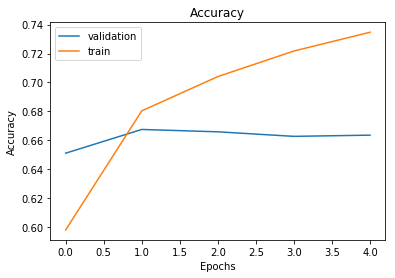

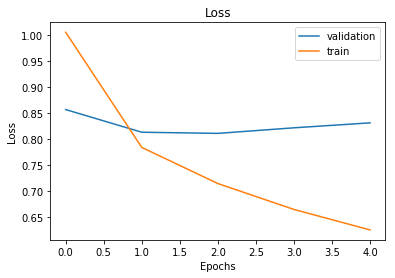

In [35]:
plt.figure(1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['val_acc'], label='validation')
plt.plot(history.history['acc'], label='train')
plt.legend()

plt.figure(2)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='train')
plt.legend()

#### As we can see below looks like after the first two epocs the model seems to hit a ceiling on learning. The validation loss and accuracy seem to diverge from the training values, so seems like the model might be over fitting beyond that. Since we have saved the values of latest improved weights, we can just use those weights instead of the updated weights after 5 epochs.

In [36]:
# First load the latest saved weights, rather than used the weights after epoch 5.
model.load_weights('./lstm_weights.best.hdf5')
# Train on the validation set.
history = model.fit(X_validate, np.array(Y_validate),
                    batch_size=batch_size, epochs=2,
                    callbacks=callbacks, verbose=1)
model.save_weights('./lstm_weights.validation_training.hdf5')

Epoch 1/2
31212/31212 [==============================] - 528s 17ms/step - loss: 0.8120 - acc: 0.6684
Epoch 2/2


/Users/noel/miniconda3/envs/movie_reviews_sentiment_analysis/lib/python3.6/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


31212/31212 [==============================] - 520s 17ms/step - loss: 0.6987 - acc: 0.7152


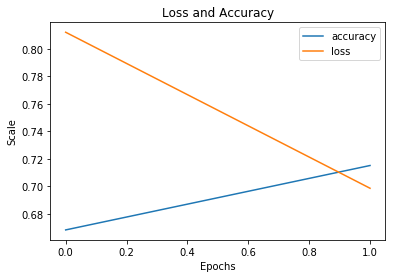

In [39]:
plt.figure(3)
plt.title('Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scale')
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend()

#### Without a validation set it is hard to see where the actual learning stops, but two epochs seem safe to prevent  over fitting, just took the number of epochs based on the previous readings. I expect beyond the last epoch here the leanring would slow, which in the previous example market the point where the validation accuracy and the actual accuracy diverged.

In [107]:
# Get test data and prepare training data.
test_reviews = pd.read_csv('data/test.tsv', sep='\t')

test_reviews['Phrase'] = test_reviews['Phrase'].str.lower()
test_reviews['Phrase'] = test_reviews['Phrase'].str.replace(r'[^a-z ]*', '', regex=True)

test_reviews['Phrase'] = test_reviews['Phrase'].map(lambda phrase: convert_vocab_to_id(phrase))
test_dict = dict(
    zip(test_reviews['PhraseId'], 
        sequence.pad_sequences(test_reviews['Phrase'], maxlen=max_phrase_size)
       )
)

In [108]:
# Evaluate
arr = np.array(list(test_dict.values()))
print(arr.shape)
prediction = model.predict(arr, verbose=1)
print(len(prediction))

(66292, 265)
66292/66292 [==============================] - 711s 11ms/step
66292


In [146]:
# Convert the predictions to the arrays:
# {0: [0, 0, 0, 1, 0], 1: [0, 0, 1, 0, 0], 2: [1, 0, 0, 0, 0], 3: [0, 1, 0, 0, 0], 4: [0, 0, 0, 0, 1]}
# So we can create a reverse lookup for them.

def conv_to_sparse(arr):
    sparse_arr = np.zeros_like(arr)
    sparse_arr[arr.argmax()] = 1
    return sparse_arr.astype(int).tolist()

sparse_predictions = [conv_to_sparse(p) for p in prediction]
final_predictions = [k for sp in sparse_predictions for k, v in targets_mapping.items() if sp == v]
len(final_predictions)

66292

(array([ 1002.,     0., 10014.,     0.,     0., 40084.,     0., 12686.,
            0.,  2506.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

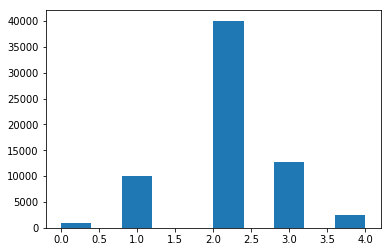

In [160]:
# Lets check the distributions of the predictions.
predictions_df = pd.DataFrame(data={'PhraseId': list(test_dict.keys()), 'Sentiment': final_predictions})
group = predictions_df.groupby(by='Sentiment').count().reset_index()
plt.hist(group['Sentiment'], weights=group['PhraseId'])

In [164]:
# Writing the data to submission file so we can see our accuracy on Kaggle.
print(predictions_df[:10])
predictions_df.to_csv('./submission.csv', index=False)

   PhraseId  Sentiment
0    156061          2
1    156062          2
2    156063          2
3    156064          2
4    156065          2
5    156066          2
6    156067          3
7    156068          2
8    156069          3
9    156070          2


#### Data Set: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews
#### After submitting the submission.csv on Kaggle. Below was the evaluated score. Maximum score on the data set was .76 and below score is in the top 200 (Which is pretty cool for my first NLP Project :P)

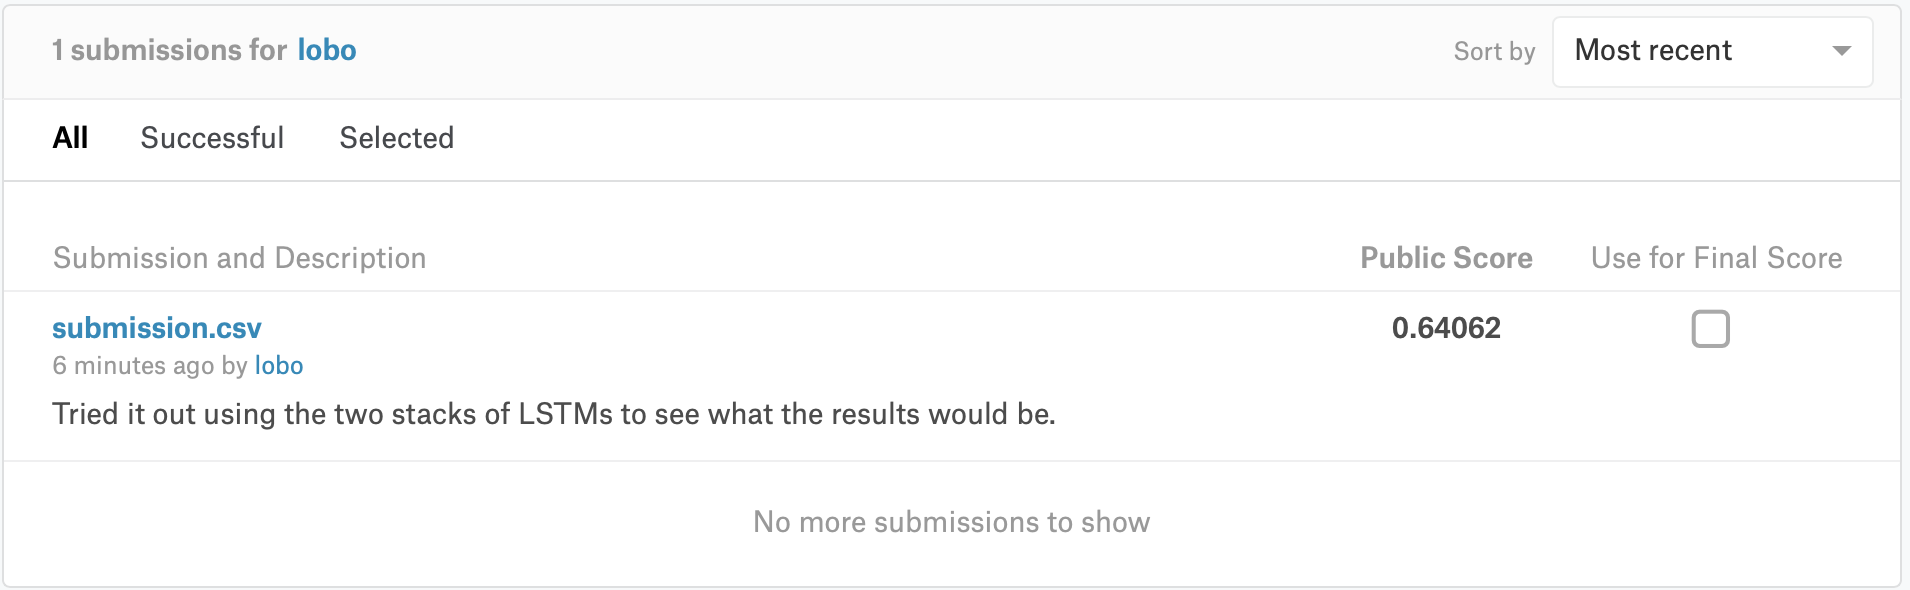